In [84]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

import numpy as np
import math
import scipy
import random

from statsmodels.distributions.empirical_distribution import ECDF
import statsmodels.formula.api as smf

import collections

some functions from previous chapters

In [2]:
def RawMoment(xs, k):
    return sum(x**k for x in xs)/len(xs)

# first row moment is mean

In [3]:
def CentralMoment(xs, k):
    mean = RawMoment(xs,1)
    
    return sum((x - mean)**k for x in xs) / len(xs)

# Second central moment is variance

In [4]:
def covariance(xs, ys):
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    
    meanx = np.mean(xs)
    meany = np.mean(ys)
    
    cov = np.dot(xs - meanx, ys - meany)/len(xs)
    
    return round(cov,2)

In [5]:
def RMSE(estimates, actual):
    error2 = [(estimate - actual)**2 for estimate in estimates]
    mse = np.mean(error2)
    rmse = math.sqrt(mse)
    
    return rmse

#  Least squares fit

In [6]:
def LeastSquares(xs,ys):
    """
    return inter, slope
    """
    x_var = CentralMoment(xs, 2)
    x_mean = np.mean(xs)
    y_mean = np.mean(ys)
    
    cov = covariance(xs, ys)
    
    slope = cov / x_var
    inter = y_mean - slope * x_mean
    
    return inter, slope

In [7]:
def FitLine(xs, inter, slope):
    """
    return x, y
    
    y = inter + x * slope
    """
    x = np.sort(xs)
    y = inter + x * slope
    
    return x, y

In [8]:
def Residuals(xs, ys, inter, slope):
    """
    return res = ys - (inter + slope * xs)
    """
    xs = np.asarray(xs)
    ys = np.asarray(ys)
    
    res = ys - (inter + slope * xs)
    
    return res

## Apply to birth weight vs mother's age

In [9]:
preg = pd.read_csv('code/preg.csv')
live = preg[preg.outcome==1]

In [10]:
live = preg[(preg.outcome==1)].dropna(subset=['agepreg', 'totalwgt_lb'])

weights = live.totalwgt_lb
ages = live.agepreg

6.829050868895037 0.01750783356498694


<AxesSubplot:xlabel='agepreg', ylabel='totalwgt_lb'>

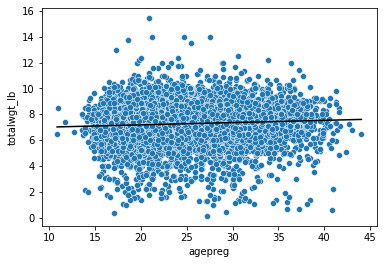

In [11]:
inter, slope = LeastSquares(ages, weights)
print(inter, slope)

fit_xs, fit_ys = FitLine(ages, inter, slope)

sns.scatterplot(x=ages, y=weights)
sns.lineplot(x=fit_xs, y=fit_ys,color='black')

[Text(0, 0.5, 'residuals')]

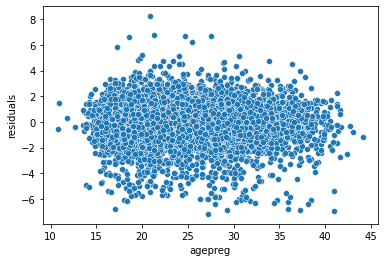

In [12]:
ress = Residuals(ages, weights, inter, slope)

sns.scatterplot(x=ages, y=ress).set(ylabel='residuals')

## Estimation

In [13]:
def SamplingDistributions(data, iters=100, plot=True):
    # test statistics
    inter_est, slope_est = LeastSquares(data.agepreg, data.totalwgt_lb)
    
    inters =[]
    slopes = []
    
    # bootstrapping
    for _ in range(iters):
        sample = data.sample(n=len(data),replace=True)
        
        ages = sample.agepreg
        weights = sample.totalwgt_lb
        
        inter, slope = LeastSquares(ages, weights)
        
        inters.append(inter)
        slopes.append(slope)
        
    print(f"interception estimation")    
    mean, stderr, ci1, ci2 = EstimationCharacterisation(inter_est, inters)
     
    print()
    print(f"slope estimation")
    mean, stderr, ci1, ci2 = EstimationCharacterisation(slope_est, slopes)
    
    
    if plot == True:
        PlotConfidenceInterval(ages.values, inters, slopes, percent=90, color='red')
        PlotConfidenceInterval(ages.values, inters, slopes, percent=50, color='black')
    
    return inters, slopes

In [14]:
def EstimationCharacterisation(estimation, estimation_variance):
    mean = np.mean(estimation_variance)
    stderr = RMSE(estimation_variance, estimation)
    
    cdf = ECDF(estimation_variance)
    
    np.sort(estimation_variance)
    
    ci_l = estimation_variance[ np.where(cdf(estimation_variance) >= 0.05)[0][0]]
    ci_u = estimation_variance[ np.where(cdf(estimation_variance) >= 0.95)[0][0]]
    
    print(f"mean = {round(mean,3)}, std error = {round(stderr,3)}, 90% confidence interval = [{round(ci_l,3)},{round(ci_u,3)}]")
    return round(mean,3), round(stderr,4), round(ci_l,4), round(ci_u,4)

In [15]:
def PlotConfidenceInterval(xdata, inters, slopes, percent=90,color='blue'):
    ys = []
    for inter, slope in zip(inters, slopes):
        x, y = FitLine(xdata, inter, slope)
        ys.append(y)
        xs = x
   
    p = (100 - percent)/2
    
    ys_sorted = np.sort(ys, axis=0)

    rows, cols = ys_sorted.shape
    
    index_l = int(rows * p / 100)
    index_u = int(rows * (100 - p) / 100)
    
    row_lower = ys_sorted[index_l,:]
    row_upper = ys_sorted[index_u,:]
    
    plt.fill_between(xs,row_lower,row_upper,color=color)
    plt.title(' 50% and 90% confidence intervals showing variability in the fitted line due to sampling error of inter and slope.')
    plt.xlabel('age')
    plt.ylabel('birth weight')
   

interception estimation
mean = 6.822, std error = 0.075, 90% confidence interval = [6.895,6.949]

slope estimation
mean = 0.018, std error = 0.003, 90% confidence interval = [0.015,0.024]


([6.895371437378341,
  6.760375243817412,
  6.796285009530444,
  6.88759293851522,
  6.820803004616562,
  6.749038591542307,
  6.752333030041101,
  6.923803583357823,
  6.841888196426051,
  6.942529977032615,
  6.8307869064835245,
  6.867928413907969,
  6.845764487133947,
  6.793700507724431,
  6.86381040785787,
  6.796132889137379,
  6.831047663294151,
  6.784121656348509,
  6.890166879741518,
  6.761019902792794,
  6.7245082162565355,
  6.73102343348988,
  6.948540599273031,
  6.722255964680068,
  6.7092068145069526,
  6.7457796583792415,
  6.915702658759651,
  6.851033424491468,
  6.841078007806441,
  6.704761843002191,
  6.724881485082685,
  6.835929632167011,
  6.83645554249821,
  6.88817343594029,
  6.779735129283561,
  6.901742870395828,
  6.852482532724861,
  6.739574186176332,
  6.827980419140934,
  6.804913482230704,
  6.838771536861089,
  6.787810060162374,
  6.7568833364566006,
  6.812071353234007,
  6.8345917300345,
  6.96059558580213,
  6.771168731486815,
  6.811828731544

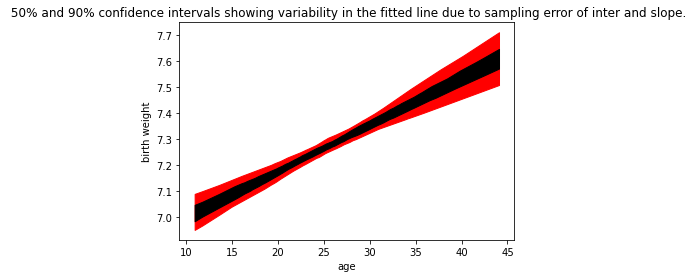

In [16]:
SamplingDistributions(live)

interception estimation
mean = 6.831, std error = 0.066, 90% confidence interval = [6.852,6.956]

slope estimation
mean = 0.017, std error = 0.003, 90% confidence interval = [0.017,0.022]


([6.851869848602164,
  6.86884990473492,
  6.916216668643084,
  6.847334320306531,
  6.900841642534037,
  6.87912361930382,
  6.77793464546394,
  6.858083526744523,
  6.955781431296719,
  6.7796093007672855,
  6.7502530726959264,
  6.744331755202355,
  6.942891603903599,
  6.880625984470538,
  6.858917558720008,
  6.884997738925914,
  6.753244355750297,
  6.775657648157176,
  6.818730633664157,
  6.8313952378255856,
  6.776350467277816,
  6.8596693597863725,
  6.825285983781994,
  6.8918024204863135,
  6.912393651905967,
  6.726700621541229,
  6.8351695581777285,
  6.747030409520147,
  6.788920986591032,
  6.773362699538585,
  6.901062458850016,
  6.75657426003607,
  6.838043226012205,
  6.82426493126516,
  6.886626805363861,
  6.70305273855329,
  6.887290821168088,
  6.77852347976231,
  6.788886009373544,
  6.892746347877162,
  6.839954915027426,
  6.8853483162423785,
  6.831412924782982,
  6.724161063297134,
  6.925233502666215,
  6.741470771187542,
  6.977098019703292,
  6.875841257

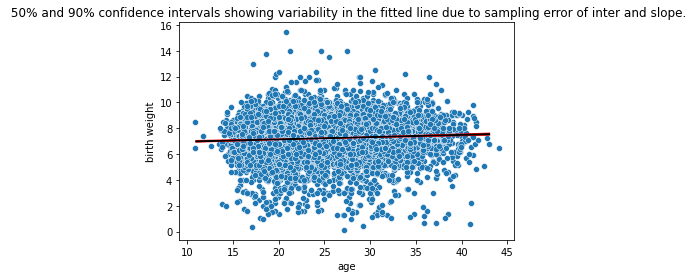

In [17]:
sns.scatterplot(x=ages, y=weights)
SamplingDistributions(live)

## Goodness of fit

In [18]:
inter, slope = LeastSquares(ages, weights)
fit_xs, fit_ys = FitLine(ages, inter, slope)

RMSE(fit_ys, weights)

1.4115683546591422

In [19]:
ress = Residuals(ages, weights, inter, slope)

RMSE(ress,0)

1.4048754607742169

My notes: they shouldn't be different, there is some rounding problem, probably

In [20]:
RMSE(inter + ages * slope, weights)

1.4115683546591402

In [21]:
RMSE(weights - inter - ages*slope, 0)

1.4048754607742169

### Coefficient of determination, R-squared

R2 = 1 - res_var/ys_var  
where *res_var/ys_var* - is the fraction of MSE that remains if you use the model, and R2 is the fraction of MSE the model eliminates.

There is a simple relationship between the coefficient of determination and **Pearson’s coefficient of correlation**:  
R2 = ρ2.  
For example, if ρ is 0.8 or -0.8, R2 = 0.64.

If you see a correlation that looks impressive, remember that R2 is a better indicator of reduction in MSE, and reduction in RMSE is a better indicator of predictive power.

In [22]:
def Rsquared(ys, res):
    ys_var = CentralMoment(ys, 2)
    res_var = CentralMoment(res, 2)
    return 1 - res_var/ys_var 

In [23]:
R2 = Rsquared(weights, Residuals(ages, weights, inter, slope))
print(f"R2 is {round(R2,5)},which means that mother’s age predicts about half of 1% of variance in birth weight.")

R2 is 0.00474,which means that mother’s age predicts about half of 1% of variance in birth weight.


#### Example with IQ and SAT
According to one study, there is a Pearson correlation of ρ=0.72 between total SAT scores and IQ scores, which sounds like a strong correlation.  
But R2 = ρ2 = 0.52, so SAT scores account for only 52% of variance in IQ.

In [24]:
std_IQ = 15
var_ys = std_IQ**2

corr_Pearson = 0.72
r2 = corr_Pearson**2

var_res = (1 - r2) * var_ys
std_res = math.sqrt(var_res)
std_res

10.409610943738484

So using SAT score to predict IQ reduces RMSE from 15 points to 10.4 points. A correlation of 0.72 yields a reduction in RMSE of only 31%.

### Testing a linear model

#### to test whether the apparent reduction in MSE is due to chance

the test statistic is R2  
the null hypothesis is that there is no relationship between the variables

In [25]:
statistic = Rsquared(weights,ress)

In [26]:
iters = 1000
counter = 0

for _ in range(iters):
    # bootstrapping with assumption, that x and y are independent
    sample_age = np.random.choice(ages, size=len(live.agepreg),replace=True)
    sample_weight = np.random.choice(weights, size=len(live.totalwgt_lb),replace=True)
    
    sample_inter, sample_slope = LeastSquares(sample_age, sample_weight)
    sample_ress = Residuals(sample_age, sample_weight,sample_inter, sample_slope)
    
    sample_stat = Rsquared(sample_weight, sample_ress)
    
    if sample_stat >= statistic:
        counter += 1
    
p_value = counter / iters
print(f"p value is {p_value},\nso we conclude that the apparent relationship between mother’s age and birth weight is statistically significant")


p value is 0.0,
so we conclude that the apparent relationship between mother’s age and birth weight is statistically significant


#### to test whether the apparent slope is due to chance
the test statistic - slope, calc by fitting  
The null hypothesis: slope=0        => we can model the birth weights as random variations around their mean

In [27]:
inter, test_stat = LeastSquares(ages, weights)

In [28]:
weight_mean = np.mean(weights)

weight_res = weights - weight_mean

iters = 1000
max_slope = 0
counter = 0
stat_dist = []
for _ in range(iters):
    sample = weight_mean + np.random.permutation(weight_res)
    
    _, sample_stat = LeastSquares(ages, sample)
    stat_dist.append(sample_stat)
    
    if sample_stat >= test_stat:
        counter += 1
        
    if sample_stat > max_slope:
        max_slope = sample_stat
        
p_value = counter / iters

print(f"P value={p_value}, max_slope={max_slope}")
    
print("The p-value is less than 0.001, so although the estimated slope is small, it is unlikely to be due to chance.")  

P value=0.0, max_slope=0.008105478502308767
The p-value is less than 0.001, so although the estimated slope is small, it is unlikely to be due to chance.


interception estimation
mean = 6.833, std error = 0.075, 90% confidence interval = [6.808,6.973]

slope estimation
mean = 0.017, std error = 0.003, 90% confidence interval = [0.02,0.023]


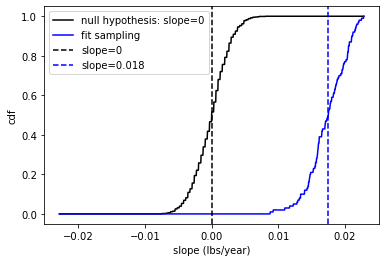

In [29]:
# from fit of sampling
inters, slopes = SamplingDistributions(live, plot=False)


x_arr = np.linspace(-max(slopes),max(slopes),1000)

cdf_sd = ECDF(slopes)
cdf_nh = ECDF(stat_dist)



sns.lineplot(x=x_arr, y=cdf_nh(x_arr), color='black')
ax = sns.lineplot(x=x_arr, y=cdf_sd(x_arr), color='blue')

plt.axvline(0,0,1,color='black',linestyle='--')
plt.axvline(test_stat,0,1,color='blue',linestyle='--')

ax.set(xlabel='slope (lbs/year)', ylabel='cdf')
plt.legend(['null hypothesis: slope=0','fit sampling', 'slope=0',f'slope={round(test_stat,3)}'])

## Weighted resampling

In [30]:
mean_weight = live.totalwgt_lb.mean()

In [31]:
def Resample(df,column1, column2):
    sample = df.sample(n=len(df), replace=True)
    
    data1 = sample[column1]
    data2 = sample[column2]
    
    return data1, data2

In [32]:
def WeightedResample(df,column1, column2, wcolumn='finalwgt'):
    w = df[wcolumn].values

    sample = df.sample(n=len(df),replace=True, weights=w)
        
    data1 = sample[column1]
    data2 = sample[column2]
    
    return data1, data2

In [33]:
iters = 100
w_arr = []
for _ in range(iters):
    _, weight = Resample(live,'agepreg','totalwgt_lb')
    w_arr.append(np.mean(weight.values))

print('non-weighted resample')
m1,b,s,d = EstimationCharacterisation(mean_weight, w_arr)

print()
# with weight
w_arr = []
for _ in range(iters):
    _, weight = WeightedResample(live,'agepreg','totalwgt_lb')
    w_arr.append(np.mean(weight.values))

print("weighted resample")
m2,b,s,d = EstimationCharacterisation(mean_weight, w_arr)

non-weighted resample
mean = 7.268, std error = 0.014, 90% confidence interval = [7.28,7.293]

weighted resample
mean = 7.348, std error = 0.084, 90% confidence interval = [7.38,7.38]


In [34]:
f"difference in means = {round(m2-m1,3)}, that is more than standart error of estimate"

'difference in means = 0.08, that is more than standart error of estimate'

## Exercises to chapter 10

In [35]:
brfss = pd.read_csv('code/brfss.csv')
brfss.dropna(subset=['htm3','wtkg2','finalwt'],inplace=True)
brfss.head()

,age,sex,wtyrago,finalwt,wtkg2,htm3
0,82.0,2,76.363636,185.870345,70.91,157.0
1,65.0,2,72.727273,126.603027,72.73,163.0
3,61.0,1,73.636364,517.926275,73.64,170.0
4,26.0,1,88.636364,1252.624630,88.64,185.0
5,42.0,1,118.181818,415.161314,109.09,183.0


In [36]:
heights = brfss.htm3
logweights = np.log(brfss.wtkg2)

In [37]:
inter, slope = LeastSquares(logweights,heights)

xs, ys = FitLine(logweights, inter, slope)

<AxesSubplot:xlabel='wtkg2', ylabel='htm3'>

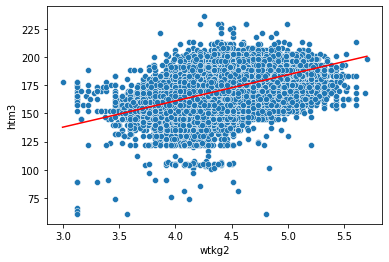

In [38]:
sns.scatterplot(x=logweights, y=heights)
sns.lineplot(x=xs,y=ys,color='red')

<AxesSubplot:xlabel='wtkg2', ylabel='htm3'>

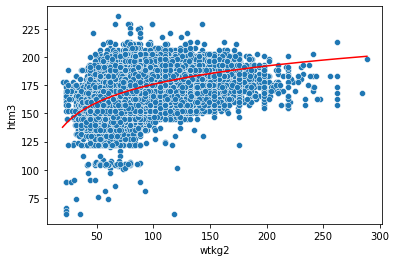

In [39]:
sns.scatterplot(x=2.7**logweights, y=heights)
sns.lineplot(x=2.7**xs,y=ys,color='red')

In [40]:
residuals = Residuals(logweights,heights, inter, slope)
Rsquared(heights, residuals)

0.2827334749582322

In [41]:
mean_height = heights.mean()

iters = 100

print('unweighted resample')
w_arr = []
for _ in range(iters):
    height, _ = Resample(brfss,'htm3', 'wtkg2')
    w_arr.append(np.mean(height.values))

m1,b,s,d = EstimationCharacterisation(mean_height, w_arr)


print()
print('unweighted resample')
w_arr = []
for _ in range(iters):
    height, _ = WeightedResample(brfss,'htm3', 'wtkg2',wcolumn='finalwt')
    w_arr.append(np.mean(height.values))

m1,b,s,d = EstimationCharacterisation(mean_height, w_arr)

unweighted resample
mean = 168.956, std error = 0.015, 90% confidence interval = [168.962,168.984]

unweighted resample
mean = 170.498, std error = 1.542, 90% confidence interval = [170.492,170.522]


# Regression

y = w0 + w*x,   
y - dependent variable   
x - explanatory variable

**simple regression** - when there is only one dependent and one explanatory variable    
**multiple regression** with more than one explanatory variable   
**multivariate regression** - if there is more than one dependent variable

## Linear regression using StatsModel

ordinary least squares

results properties:   
**.summary()**   
**.params** ['Intercept']   
**.params** [x_name]   
**.pvalues** [x_name] - p-value of slop
**.f_pvalue** - p-value of model   
**.rsquared**

**.resid** - a sequence of residuals    
**.fittedvalues** - a sequence of fitted values corresponding to x

In [43]:
formula = 'totalwgt_lb ~ agepreg'
model = smf.ols(formula, data=live)
results = model.fit()

In [46]:
inter = results.params['Intercept']
slope = results.params['agepreg']

print(inter, slope)

6.830396973311048 0.017453851471802843


In [54]:
print(f"p-value of slope is {round(results.pvalues['agepreg'],6)}")

p-value of slope is 0.0


In [57]:
print(f"p-value of model as a whole is {round(results.f_pvalue,6)} (similar to testing whether R2 is statistically significant)")

p-value of model as a whole is 0.0 (similar to testing whether R2 is statistically significant)


In [52]:
print(f"R2 is {round(results.rsquared,4)}")

R2 is 0.0047


In [58]:
print(f"{results.fittedvalues}")

0        7.409167
1        7.515461
2        7.080511
3        7.141599
4        7.150326
           ...   
13581    7.365532
13584    7.300080
13588    7.142995
13591    7.207051
13592    7.207051
Length: 9038, dtype: float64


In [59]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totalwgt_lb   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     43.02
Date:                Thu, 18 Nov 2021   Prob (F-statistic):           5.72e-11
Time:                        11:52:54   Log-Likelihood:                -15897.
No. Observations:                9038   AIC:                         3.180e+04
Df Residuals:                    9036   BIC:                         3.181e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      6.8304      0.068    100.470      0.000       6.697       6.964
agepreg        0.0175      0.003      6.559      0.000       0.012       0.023
==============================================================================
Omnibus:                     1024.052   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3081.833
Skew:                          -0.601   Prob(JB):                         0.00
Kurtosis:                       5.596   Cond. No.                         118.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [65]:
f"Std(ys) = {round(live.totalwgt_lb.std(),4)} is the standard deviation of the dependent variable, which is the RMSE if you have to guess birth weights without the benefit of any explanatory variables."

'Std(ys) = 1.4083 is the standard deviation of the dependent variable, which is the RMSE if you have to guess birth weights without the benefit of any explanatory variables.'

In [67]:
f"Std(res) = {round(results.resid.std(),4)} is the standard deviation of the residuals, which is the RMSE if your guesses are informed by the mother’s age."

'Std(res) = 1.405 is the standard deviation of the residuals, which is the RMSE if your guesses are informed by the mother’s age.'

## Multiple regression

In [68]:
firsts = live[live.birthord == 1]
others = live[live.birthord != 1]

In [75]:
diff_weight = firsts.totalwgt_lb.mean() - others.totalwgt_lb.mean()
diff_age = firsts.agepreg.mean() - others.agepreg.mean()

print(diff_weight, diff_age)

-0.12476118453549034 -3.558721516986065


In [77]:
slope*diff_age

-0.062113396786983674

The result is just about half of the observed difference. So we conclude, tentatively, that the observed difference in birth weight can be partly explained by the difference in mother’s age.

### check totalwgt_lb ~ isfirst dependens

live['isfirst'] = live.birthord==1

In [79]:
formula = 'totalwgt_lb ~ isfirst'
results = smf.ols(formula, data=live).fit()

In [80]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totalwgt_lb   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                  0.002
Method:                 Least Squares   F-statistic:                     17.74
Date:                Thu, 18 Nov 2021   Prob (F-statistic):           2.55e-05
Time:                        12:17:32   Log-Likelihood:                -15909.
No. Observations:                9038   AIC:                         3.182e+04
Df Residuals:                    9036   BIC:                         3.184e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           7.3259      0.021    356.007      0.000       7.286       7.366
isfirst[T.True]    -0.1248      0.030     -4.212      0.000      -0.183      -0.067
==============================================================================
Omnibus:                      988.919   Durbin-Watson:                   1.613
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             2897.107
Skew:                          -0.589   Prob(JB):                         0.00
Kurtosis:                       5.511   Cond. No.                         2.58
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### check    totalwgt_lb ~ isfirst + agepreg

In [81]:
formula = 'totalwgt_lb ~ isfirst + agepreg'
results = smf.ols(formula, data=live).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totalwgt_lb   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.005
Method:                 Least Squares   F-statistic:                     24.02
Date:                Thu, 18 Nov 2021   Prob (F-statistic):           3.95e-11
Time:                        12:19:57   Log-Likelihood:                -15894.
No. Observations:                9038   AIC:                         3.179e+04
Df Residuals:                    9035   BIC:                         3.182e+04
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           6.9142      0.078     89.073      0.000       6.762       7.066
isfirst[T.True]    -0.0698      0.031     -2.236      0.025      -0.131      -0.009
agepreg             0.0154      0.003      5.499      0.000       0.010       0.021
==============================================================================
Omnibus:                     1019.945   Durbin-Watson:                   1.618
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3063.682
Skew:                          -0.599   Prob(JB):                         0.00
Kurtosis:                       5.588   Cond. No.                         137.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In the combined model, the parameter for isfirst is smaller by about half, which means that part of the apparent effect of isfirst is actually accounted for by agepreg. And the p-value for isfirst is about 2.5%, which is on the border of statistical significance.

R2 for this model is a little higher, which indicates that the two variables together account for more variation in birth weight than either alone (but not by much).

## Nonlinear relationships

In [82]:
live['agepreg2'] = live.agepreg**2

In [83]:
formula = 'totalwgt_lb ~ isfirst + agepreg + agepreg2'
results = smf.ols(formula, data=live).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totalwgt_lb   R-squared:                       0.007
Model:                            OLS   Adj. R-squared:                  0.007
Method:                 Least Squares   F-statistic:                     22.64
Date:                Thu, 18 Nov 2021   Prob (F-statistic):           1.35e-14
Time:                        12:26:00   Log-Likelihood:                -15884.
No. Observations:                9038   AIC:                         3.178e+04
Df Residuals:                    9034   BIC:                         3.181e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
===================================================================================
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           5.6923      0.286     19.937      0.000       5.133       6.252
isfirst[T.True]    -0.0504      0.031     -1.602      0.109      -0.112       0.011
agepreg             0.1124      0.022      5.113      0.000       0.069       0.155
agepreg2           -0.0018      0.000     -4.447      0.000      -0.003      -0.001
==============================================================================
Omnibus:                     1007.149   Durbin-Watson:                   1.616
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3003.343
Skew:                          -0.594   Prob(JB):                         0.00
Kurtosis:                       5.562   Cond. No.                     1.39e+04
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.39e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

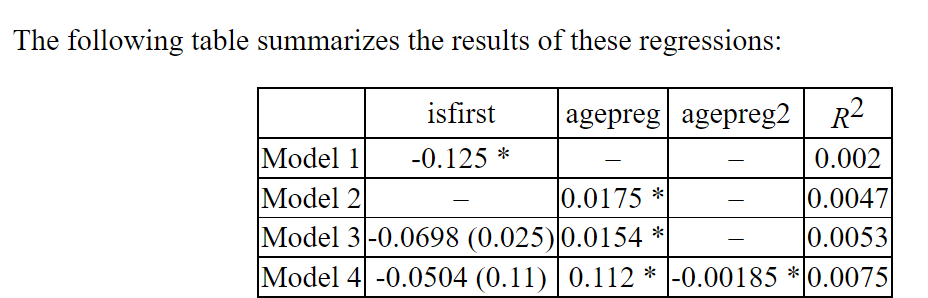
We conclude that the apparent difference in birth weight is explained, at least in part, by the difference in mother’s age. When we include mother’s age in the model, the effect of isfirst gets smaller, and the remaining effect might be due to chance.

## Data mining   
Sometimes you start with a theory and use data to test it. Other times you start with data and go looking for possible theories. The second approach, which this section demonstrates, is called **data mining**. An advantage of data mining is that it can discover unexpected patterns. A hazard is that many of the patterns it discovers are either random or spurious.

In [92]:
resp = pd.read_csv('code/resp.csv')
resp.index = resp.caseid

In [93]:
join = live.join(resp, on='caseid', rsuffix='_r')

In [94]:
join.head()

,caseid,pregordr,howpreg_n,howpreg_p,moscurrp,nowprgdk,pregend1,pregend2,nbrnaliv,multbrth,...,pubassis_i_r,basewgt_r,adj_mod_basewgt_r,finalwgt_r,secu_r,sest_r,cmintvw_r,cmlstyr,screentime,intvlngth
0,1,1,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,3410.389399,3869.349602,6448.271112,2,9,1231,1219,19:56:43,67.563833
1,1,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,3410.389399,3869.349602,6448.271112,2,9,1231,1219,19:56:43,67.563833
2,2,1,NaN,NaN,NaN,NaN,5.0,NaN,3.0,5.0,...,0,7226.301740,8567.549110,12999.542264,2,12,1231,1219,14:54:03,106.018167
3,2,2,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,7226.301740,8567.549110,12999.542264,2,12,1231,1219,14:54:03,106.018167
4,2,3,NaN,NaN,NaN,NaN,6.0,NaN,1.0,NaN,...,0,7226.301740,8567.549110,12999.542264,2,12,1231,1219,14:54:03,106.018167


In [101]:
# For each variable we construct a model, compute R2, and append the results to a list. 
# The models all include agepreg, since we already know that it has some predictive power.

t = []

for name in join.columns:
    try:
        # check that each explanatory variable has some variability; 
        # otherwise the results of the regression are unreliable
        if join[name].var() < 1e-7:
            continue
            
        formula = 'totalwgt_lb ~ agepreg + ' + name
        model = smf.ols(formula, data = join)
        
        #  check the number of observations for each model. 
        # Variables that contain a large number of nans are not good candidates for prediction
        if model.nobs < len(join)/2:
            continue
            
        results = model.fit()
        
    except (ValueError, TypeError):
        continue

    t.append( (results.rsquared, name) )

In [102]:
# select the variables that yield the highest values of R2
t.sort(reverse=True)

for rr, name in t:
    print(name, rr)

totalwgt_lb 1.0
birthwgt_lb 0.9587862870136684
lbw1 0.40561200604817416
prglngth 0.24796143194924125
wksgest 0.24042419845681307
agecon 0.2164512812618018
mosgest 0.07741802616852689
nbrnaliv 0.021543432730345646
race_r 0.018113300115492947
race 0.018113300115492947
babysex 0.015718299930559954
canhaver 0.014205394660633308
rmarout03 0.013980426565210702
anynurse 0.013952843721660058
birthwgt_oz 0.013491247023814212
bfeedwks 0.013304843666055555
paydu 0.012726264667475728
marcon03 0.012702868845044568
marout03 0.012665151210496162
hisprace_r 0.012304055565273586
hisprace 0.012304055565273586
rmarout6 0.012144473716538484
totincr 0.01192936294936342
rmarout02 0.011786202889545572
rmarout01 0.011637769057989411
marout01 0.011402233733051381
marout02 0.01132997531131208
marcon02 0.011279910720394803
ssi 0.011268567859541223
fmarital_r 0.011092780095621535
fmarital 0.011092780095621535
fmarit 0.011092780095621535
fmarout5 0.011043292892801593
cebow 0.01096953854307925
fmarcon5 0.0107259435

nummult37 0.00493294856498272
datend01 0.004931613318621797
methhist321 0.004930881553892652
posiblpg 0.004930850373809137
methhist241 0.004928853056222149
nummult6 0.004928364736151103
laborfor_i_r 0.004927403762965965
laborfor_i 0.004927403762965965
sest_r 0.004927298532681257
sest 0.004927298532681257
nummult36 0.004927006404224499
methhist361 0.004925781709499311
everothr 0.004919024365199864
foamalon 0.004917942547708387
agecon06_i 0.004916921692986187
jelcrmal 0.004915510202163298
wantp03_i 0.004913914485500492
methhist161 0.004909983088554393
wantrp02_i 0.004909204843865256
oldwr02_i 0.004909204843865256
cmintvw_r 0.004907629865820384
cmlstyr 0.004907629865820162
mthuse3_i 0.004907567975096838
acasilang 0.0049070262779781215
prgvisit 0.0049067503334273566
fptit12_i 0.004906345733998618
methhist231 0.00490453485685638
hispanic_r 0.0049031383453004285
hispanic 0.0049031383453004285
nummult31 0.0049019030711946465
hisp 0.004899361362460275
reldlife 0.004897559393379214
cmlstprg_r 0

In [103]:
formula = ('totalwgt_lb ~ agepreg + C(race) + babysex==1 + nbrnaliv>1 + paydu==1 + totincr')
results = smf.ols(formula, data=join).fit()

results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            totalwgt_lb   R-squared:                       0.067
Model:                            OLS   Adj. R-squared:                  0.066
Method:                 Least Squares   F-statistic:                     92.14
Date:                Thu, 18 Nov 2021   Prob (F-statistic):          2.48e-130
Time:                        13:48:57   Log-Likelihood:                -15607.
No. Observations:                9038   AIC:                         3.123e+04
Df Residuals:                    9030   BIC:                         3.129e+04
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
========================================================================================
                           coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------
Intercept                6.4844      0.070     92.048      0.000       6.346       6.622
C(race)[T.2]             0.4217      0.034     12.255      0.000       0.354       0.489
C(race)[T.3]             0.3396      0.056      6.065      0.000       0.230       0.449
babysex == 1[T.True]     0.2965      0.029     10.353      0.000       0.240       0.353
nbrnaliv > 1[T.True]    -1.6681      0.109    -15.338      0.000      -1.881      -1.455
paydu == 1[T.True]       0.1192      0.034      3.537      0.000       0.053       0.185
agepreg                  0.0070      0.003      2.525      0.012       0.002       0.012
totincr                  0.0151      0.004      3.530      0.000       0.007       0.023
==============================================================================
Omnibus:                      986.934   Durbin-Watson:                   1.633
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             3348.110
Skew:                          -0.544   Prob(JB):                         0.00
Kurtosis:                       5.776   Cond. No.                         205.
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

## Logistic regression
**logistic regression** - if the dependent variable is boolean   
**Poisson regression** -if the dependent variable is an integer count

In [104]:
y = np.array([0, 1, 0, 1])
x1 = np.array([0, 0, 0, 1])
x2 = np.array([0, 1, 1, 1])

In [105]:
beta = [-1.5, 2.8, 1.1]

In [107]:
log_o = beta[0] + beta[1] * x1 + beta[2] * x2
log_o

array([-1.5, -0.4, -0.4,  2.4])

In [113]:
# odds
o = np.exp(log_o)
o

array([ 0.22313016,  0.67032005,  0.67032005, 11.02317638])

In [114]:
# probability
p = o / (o+1)
p

array([0.18242552, 0.40131234, 0.40131234, 0.9168273 ])

In [115]:
likes = y * p + (1-y) * (1-p)
likes

array([0.81757448, 0.40131234, 0.59868766, 0.9168273 ])

In [117]:
# the overall likelihood of the data
like = np.prod(likes)
like

0.1800933529673034

The goal of logistic regression is to find parameters that maximize this likelihood.

In [118]:
live = preg[(preg.outcome==1) & (preg.prglngth > 30)]

In [120]:
live['boy'] = (live.babysex==1).astype(int)

<ipython-input-120-710487c41543>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  live['boy'] = (live.babysex==1).astype(int)


In [125]:
model = smf.logit('boy ~ agepreg', data=live)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.693015
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    boy   No. Observations:                 8884
Model:                          Logit   Df Residuals:                     8882
Method:                           MLE   Df Model:                            1
Date:                Thu, 18 Nov 2021   Pseudo R-squ.:               6.144e-06
Time:                        15:45:24   Log-Likelihood:                -6156.7
converged:                       True   LL-Null:                       -6156.8
Covariance Type:            nonrobust   LLR p-value:                    0.7833
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      0.0058      0.098      0.059      0.953      -0.185       0.197
agepreg        0.0010      0.004      0.275      0.783      -0.006       0.009
==============================================================================
"""

In [127]:
formula = 'boy ~ agepreg + hpagelb + birthord + C(race)'
model = smf.logit(formula, data=live)
results = model.fit()
results.summary()

Optimization terminated successfully.
         Current function value: 0.692944
         Iterations 3


<class 'statsmodels.iolib.summary.Summary'>
"""
                           Logit Regression Results                           
==============================================================================
Dep. Variable:                    boy   No. Observations:                 8782
Model:                          Logit   Df Residuals:                     8776
Method:                           MLE   Df Model:                            5
Date:                Thu, 18 Nov 2021   Pseudo R-squ.:               0.0001440
Time:                        15:47:39   Log-Likelihood:                -6085.4
converged:                       True   LL-Null:                       -6086.3
Covariance Type:            nonrobust   LLR p-value:                    0.8822
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.0301      0.104     -0.290      0.772      -0.234       0.173
C(race)[T.2]    -0.0224      0.051     -0.439      0.660      -0.122       0.077
C(race)[T.3]    -0.0005      0.083     -0.005      0.996      -0.163       0.162
agepreg         -0.0027      0.006     -0.484      0.629      -0.014       0.008
hpagelb          0.0047      0.004      1.112      0.266      -0.004       0.013
birthord         0.0050      0.022      0.227      0.821      -0.038       0.048
================================================================================
"""

None of the estimated parameters are statistically significant. The pseudo-R2 value is a little higher, but that could be due to chance.

In [139]:
# endogenous variable - dependent variable
endog = pd.DataFrame(model.endog, columns=[model.endog_names])

# exogenous variables - explanatory variables
exog = pd.DataFrame(model.exog, columns=model.exog_names)

### Accuracy

In [129]:
baseline = live.boy.mean()
baseline

0.5079918955425484

In [144]:
predict = results.predict() >= 0.5
actual = endog['boy']
true_positive = predict * actual
true_negative = (1-predict)*(1-actual)

In [146]:
accuracy = (sum(true_positive) + sum(true_negative)) / len(actual)
accuracy


0.5115007970849464

make prediction

In [147]:
columns = ['agepreg', 'hpagelb', 'birthord', 'race']
new = pd.DataFrame([[35, 39, 3, 2]], columns=columns)
results.predict(new)

0    0.513091
dtype: float64

## Execises to shapter 11

### Exercise 1

In [161]:
join = join[join.prglngth>30]

In [162]:
pd.set_option('display.max_rows', None)
join.head().transpose()

,0,1,2,3,4
caseid,1,1,2,2,2
pregordr,1,2,1,2,3
howpreg_n,NaN,NaN,NaN,NaN,NaN
howpreg_p,NaN,NaN,NaN,NaN,NaN
moscurrp,NaN,NaN,NaN,NaN,NaN
nowprgdk,NaN,NaN,NaN,NaN,NaN
pregend1,6,6,5,6,6
pregend2,NaN,NaN,NaN,NaN,NaN
nbrnaliv,1,1,3,1,1
multbrth,NaN,NaN,5,NaN,NaN


In [171]:
formula = 'prglngth ~ C(race) +nbrnaliv>1 + totincr +birthord==1'
results = smf.ols(formula, data=join).fit()
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:               prglngth   R-squared:                       0.012
Model:                            OLS   Adj. R-squared:                  0.012
Method:                 Least Squares   F-statistic:                     21.71
Date:                Thu, 18 Nov 2021   Prob (F-statistic):           1.13e-21
Time:                        16:17:42   Log-Likelihood:                -18054.
No. Observations:                8781   AIC:                         3.612e+04
Df Residuals:                    8775   BIC:                         3.616e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                38.6898      0.056    685.969      0.000      38.579      38.800
C(race)[T.2]              0.1162      0.048      2.422      0.015       0.022       0.210
C(race)[T.3]             -0.0124      0.079     -0.157      0.875      -0.167       0.142
nbrnaliv > 1[T.True]     -1.5046      0.166     -9.089      0.000      -1.829      -1.180
birthord == 1[T.True]     0.1044      0.041      2.575      0.010       0.025       0.184
totincr                   0.0108      0.005      2.047      0.041       0.000       0.021
==============================================================================
Omnibus:                     1575.817   Durbin-Watson:                   1.620
Prob(Omnibus):                  0.000   Jarque-Bera (JB):             6101.278
Skew:                          -0.856   Prob(JB):                         0.00
Kurtosis:                       6.707   Cond. No.                         76.5
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### Exercise 2

In [173]:
join['boy'] =(join.babysex==1).astype(int)

In [174]:
t = []

for name in join.columns:
    try:
        # check that each explanatory variable has some variability; 
        # otherwise the results of the regression are unreliable
        if join[name].var() < 1e-7:
            continue
            
        formula = 'boy ~ ' + name
        model = smf.ols(formula, data = join)
        
        #  check the number of observations for each model. 
        # Variables that contain a large number of nans are not good candidates for prediction
        if model.nobs < len(join)/2:
            continue
            
        results = model.fit()
        
    except (ValueError, TypeError):
        continue

    t.append( (results.rsquared, name) )

In [176]:
t.sort(reverse=True)

for rr, name in t:
    print(round(rr,3), name)

1.0 boy
1.0 babysex
0.013 totalwgt_lb
0.013 birthwgt_lb
0.002 lbw1
0.001 constat3
0.001 infever
0.001 fmarout5
0.001 nplaced
0.001 coh1dur
0.001 outcom02
0.001 rmarout6
0.001 usefstp
0.001 splstwk1
0.001 agepreg_i
0.001 abort12
0.001 pmarpreg
0.001 nummult34
0.001 hlpmc
0.001 mar1con1_i
0.001 marout03
0.001 anymschp
0.001 brnout_r
0.001 brnout
0.001 frsteatd
0.001 numfirsm1
0.001 educmom
0.001 nummult41
0.001 rmarout03
0.001 agecon_i
0.001 p1yhsage
0.001 nummult17
0.001 datcon01_i
0.001 nummult39
0.001 datend02
0.001 nummult16
0.001 pidtreat_i
0.001 numbcvis
0.001 educmom_i
0.001 nummult35
0.001 nummult43
0.001 stdtst12
0.001 lossnum
0.001 vry1stsx
0.001 spnumjob
0.001 cmdobch
0.001 anyopsmn
0.001 numfirsm
0.001 nummult33
0.001 datend06_i
0.001 datcon06_i
0.001 datesex1_i
0.001 evwntano
0.001 pwant
0.001 births5
0.001 anymster
0.001 cmintstr
0.001 intr_ec3
0.001 bpa_bdscheck1
0.001 fmarcon5
0.001 sexmar
0.001 pap12
0.001 anyprghp
0.001 fpage
0.001 con1mar1_i
0.001 mar1bir1
0.001 sex1fo

### Exercise 3

In [ ]:
results = smf.poisson('numbabes ~ agepreg + C(race) + hieduc + totincr', data=join).fit()
results.summary()

In [183]:
columns = ['agepreg', 'race', 'hieduc', 'totincr']
new = pd.DataFrame([[35,1,11,11]],columns=columns)
results.predict(new)

0    2.911785
dtype: float64

### Exercise 4
1 = Currently married   
2 = Not married but living with a partner or boyfriend   
3 = Widowed   
4 = Divorced   
5 = Separated (for reasons of marital discord)   
6 = Never been married   

<AxesSubplot:xlabel='rmarital', ylabel='totincr'>

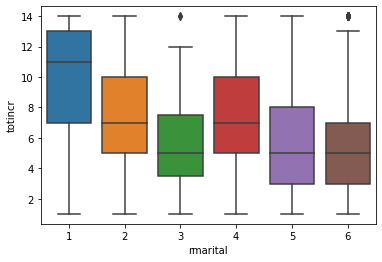

In [188]:
sns.boxplot(x=join.rmarital, y=join.totincr)

In [191]:
results = smf.mnlogit('rmarital ~ agepreg + C(race) + hieduc + totincr', data=join).fit()
results.summary()

Optimization terminated successfully.
         Current function value: 1.106554
         Iterations 8


<class 'statsmodels.iolib.summary.Summary'>
"""
                          MNLogit Regression Results                          
==============================================================================
Dep. Variable:               rmarital   No. Observations:                 8781
Model:                        MNLogit   Df Residuals:                     8751
Method:                           MLE   Df Model:                           25
Date:                Thu, 18 Nov 2021   Pseudo R-squ.:                  0.1487
Time:                        18:45:54   Log-Likelihood:                -9716.7
converged:                       True   LL-Null:                       -11414.
Covariance Type:            nonrobust   LLR p-value:                     0.000
================================================================================
  rmarital=2       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        3.2887      0.220     14.960      0.000       2.858       3.720
C(race)[T.2]    -0.7746      0.089     -8.743      0.000      -0.948      -0.601
C(race)[T.3]    -0.4818      0.136     -3.549      0.000      -0.748      -0.216
agepreg         -0.0770      0.008     -9.757      0.000      -0.092      -0.062
hieduc          -0.1508      0.019     -8.086      0.000      -0.187      -0.114
totincr         -0.1415      0.012    -12.289      0.000      -0.164      -0.119
--------------------------------------------------------------------------------
  rmarital=3       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept       -0.6720      0.578     -1.162      0.245      -1.805       0.462
C(race)[T.2]    -0.5201      0.240     -2.168      0.030      -0.990      -0.050
C(race)[T.3]    -0.1014      0.334     -0.303      0.762      -0.757       0.554
agepreg          0.0074      0.019      0.391      0.696      -0.030       0.044
hieduc          -0.0741      0.048     -1.548      0.122      -0.168       0.020
totincr         -0.3069      0.032     -9.621      0.000      -0.369      -0.244
--------------------------------------------------------------------------------
  rmarital=4       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        0.2065      0.227      0.909      0.363      -0.239       0.652
C(race)[T.2]    -0.3268      0.093     -3.495      0.000      -0.510      -0.144
C(race)[T.3]    -0.9885      0.180     -5.486      0.000      -1.342      -0.635
agepreg         -0.0389      0.008     -5.097      0.000      -0.054      -0.024
hieduc           0.1174      0.020      5.865      0.000       0.078       0.157
totincr         -0.2071      0.011    -18.118      0.000      -0.229      -0.185
--------------------------------------------------------------------------------
  rmarital=5       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        2.0500      0.274      7.476      0.000       1.513       2.587
C(race)[T.2]    -1.0212      0.105     -9.754      0.000      -1.226      -0.816
C(race)[T.3]    -0.5723      0.158     -3.618      0.000      -0.882      -0.262
agepreg         -0.0581      0.010     -6.086      0.000      -0.077      -0.039
hieduc           0.0190      0.023      0.819      0.413      -0.027       0.065
totincr         -0.2870      0.015    -19.681      0.000      -0.316      -0.258
--------------------------------------------------------------------------------
  rmarital=6       coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
Intercept        4.9999      0.218     22.891      0.000       4.572       5.428
C

In [192]:
columns = ['agepreg', 'race', 'hieduc', 'totincr']
new = pd.DataFrame([[25,2,9,6]],columns=columns)
results.predict(new)

,0,1,2,3,4,5
0,0.543052,0.107877,0.016138,0.151073,0.075393,0.106466
